---

<div style="text-align:center;">
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQEsrsQCfnH2Hj3LY-0UAOfhAPehUnhV2BP3g&s"
       alt="Ejemplo de imagen"
       width="400"
       height="auto" />
</div>

# Proyecto Final de la Maestría en Inteligencia Artificial Aplicada

---

## Modelo Predictivo de Rodamiento de Morosidad de crédito

**Autor:** Edwin David Simbaña Farinango  
**Fecha:** Mayo de 2025   
**Institución:** Universidad de los Hemisferios


### Descripción

Este notebook contiene el desarrollo y análisis de un modelo predictivo para la gestión de cobranza, enfocado en la probabilidad de empeoramiento de la morosidad, esto es, analizar el rodamiento de un rango de mora a otro mayor. Se incluyen la simulación de variables críticas, la construcción del modelo y recomendaciones para optimizar la recuperación de cartera.

### Contenido

- [Introducción](#Introducción)
- [Simulación de variables](#Simulación-de-variables)
- [Definición de la variable objetivo](#Definición-de-la-variable-objetivo)
- [Análisis exploratorio de los datos](#Análisis-exploratorio-de-los-datos)
- [Selección de variables](#Selección-de-variables)
- [Construcción del modelo predictivo (Clasificación binaria)](#Construcción-del-modelo-predictivo-(Clasificación-binaria))
- [Evaluación y métricas del modelo e iteración ganadora](#Evaluación-y-métricas-del-modelo-e-iteración-ganadora)
---

## Introducción

Dentro de las instituciones financieras, la gestión de cobranza es un proceso crítico y fundamental para mantener un buen nivel de salud financiera a nivel de la cartera crediticia, ya que, permite minimizar la morosidad producto por la falta de pago de las operaciones crediticias. 

Producto de esto, es muy difícil anticipar el evento de empeoramiento de la morosidad, es decir, que un cliente inicialmente posea un rango de mora bajo o nulo y que en los periodos posteriores empeore a un rango de morosidad mayor. Esto incrementa el riesgo asociado a no lograr la recuperación del valor adeudado y al mismo tiempo incrementa los costos asociados a la gestión de la cobranza.

En la actualidad, es muy común que las instituciones financieras utilicen e implementen reglas fijas o modelos de scoring obsoletos que no logran capturar la naturaleza cambiante en el tiempo ni el comportamiento del cliente.

Estos procesos anticuados son susceptibles a mejora mediante el uso de modelos analíticos de Machine Learning que permitan predecir con anticipación el evento de empeoramiento de un rango de mora a otro peor, permitiendo diseñar estrategias efectivas, dinámicas y personalizadas para la priorización de la gestión de cobranza según cada segmento de clientes, optimizando los recursos disponibles y costos y a la vez aumentar la recuperación.

Para este caso práctico se propone desarrollar un modelo de Machine Learning supervisado, específicamente, un modelo de clasificación binaria, que prediga la probabilidad de una cliente migre a un rango de morosidad más elevado dentro del siguiente periodo de tiempo. 

## Simulación de variables

Se decidió a simular las variables de la base de datos debido a que no se logró encontrar una base de datos libre con tal nivel de detalle. Por tanto, se simularon las variables a partir de valores aleatorios que siguen una distribución definida con cierta dependencia a la variable dependiente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)
n = 100000

In [3]:
# 1. Variable objetivo con 30% de casos positivos (empeoramiento)
empeora_mora = np.random.binomial(1, 0.3, n)

# 2. Variables SocioDemográficas simuladas condicionalmente

genero = np.where(np.random.rand(n) < 0.5, 'M', 'F')

edad = np.where(empeora_mora == 1,
                np.random.randint(25, 65, n),
                np.random.randint(30, 70, n))

ingresos = np.where(empeora_mora == 1,
                    np.random.normal(2000, 600, n),
                    np.random.normal(4500, 1200, n))
ingresos = np.clip(ingresos, 500, None)

egresos = ingresos * np.where(empeora_mora == 1,
                              np.random.uniform(0.7, 0.95, n),
                              np.random.uniform(0.4, 0.7, n))

patrimonio = np.where(empeora_mora == 1,
                      np.random.normal(30000, 15000, n),
                      np.random.normal(70000, 30000, n))
patrimonio = np.clip(patrimonio, 1000, None)

nivelEndeudamiento = np.where(empeora_mora == 1,
                              np.random.uniform(1.2, 2.5, n),
                              np.random.uniform(0.2, 1.0, n))

relacionDeudaIngreso = np.where(empeora_mora == 1,
                                np.random.uniform(1.0, 3.0, n),
                                np.random.uniform(0.1, 1.0, n))

estadoCivil = []
for val in empeora_mora:
    if val == 1:
        estadoCivil.append(np.random.choice(['SOLTERO', 'CASADO', 'DIVORCIADO', 'VIUDO'], p=[0.2, 0.3, 0.3, 0.2]))
    else:
        estadoCivil.append(np.random.choice(['SOLTERO', 'CASADO', 'DIVORCIADO', 'VIUDO'], p=[0.4, 0.5, 0.05, 0.05]))

educacion = []
for val in empeora_mora:
    if val == 1:
        educacion.append(np.random.choice(['SIN EDUCACION', 'PRIMARIA', 'SECUNDARIA', 'TERCER CUARTO'], p=[0.3, 0.3, 0.3, 0.1]))
    else:
        educacion.append(np.random.choice(['SIN EDUCACION', 'PRIMARIA', 'SECUNDARIA', 'TERCER CUARTO'], p=[0.05, 0.15, 0.5, 0.3]))

vivienda = []
for val in empeora_mora:
    if val == 1:
        vivienda.append(np.random.choice(['PROPIA', 'FAMILIAR', 'OTRA'], p=[0.3, 0.4, 0.3]))
    else:
        vivienda.append(np.random.choice(['PROPIA', 'FAMILIAR', 'OTRA'], p=[0.6, 0.3, 0.1]))

aniosTrabajo = np.where(empeora_mora == 1,
                        np.random.randint(0, 10, n),
                        np.random.randint(5, 40, n))

# 3. Variables Cartera

tipoCredito = []
for val in empeora_mora:
    if val == 1:
        tipoCredito.append(np.random.choice(['Consumo', 'Hipotecario', 'Comercial'], p=[0.7, 0.2, 0.1]))
    else:
        tipoCredito.append(np.random.choice(['Consumo', 'Hipotecario', 'Comercial'], p=[0.4, 0.4, 0.2]))

montoCredito = np.where(empeora_mora == 1,
                        np.random.normal(25000, 10000, n),
                        np.random.normal(15000, 7000, n))
montoCredito = np.clip(montoCredito, 1000, None)

plazoCuotas = np.where(empeora_mora == 1,
                       np.random.randint(6, 48, n),
                       np.random.randint(12, 360, n))

# 4. Variables Pasivos - saldoCuentasUltMes con alta correlación temporal

saldoCuentasUltMes = np.zeros((n,6))

# Generar primer mes con distribución condicionada
saldoCuentasUltMes[:,0] = np.where(empeora_mora == 1,
                                  np.random.uniform(0, 5000, n),
                                  np.random.uniform(1000, 20000, n))

# Generar meses siguientes con alta correlación (ejemplo coef 0.75)
for i in range(1,6):
    saldoCuentasUltMes[:,i] = 0.75 * saldoCuentasUltMes[:,i-1] + np.random.uniform(-500, 500, n)
    # Evitar valores negativos
    saldoCuentasUltMes[:,i] = np.clip(saldoCuentasUltMes[:,i], 0, None)

nroCuentas = np.where(empeora_mora == 1,
                      np.random.randint(1, 3, n),
                      np.random.randint(2, 6, n))

nroPolizas = np.where(empeora_mora == 1,
                      np.random.randint(0, 1, n),
                      np.random.randint(1, 4, n))

nroTarjetasCredito = np.where(empeora_mora == 1,
                             np.random.randint(0, 2, n),
                             np.random.randint(1, 5, n))

# 5. Variables Buró

nroCreditosSistFinan = np.where(empeora_mora == 1,
                               np.random.randint(1, 5, n),
                               np.random.randint(3, 10, n))

nroTarjCredSistFinan = np.where(empeora_mora == 1,
                               np.random.randint(0, 2, n),
                               np.random.randint(1, 5, n))

deudaSistFinan = np.where(empeora_mora == 1,
                          np.random.uniform(10000, 50000, n),
                          np.random.uniform(1000, 20000, n))

scoreBuro = np.where(empeora_mora == 1,
                     np.random.normal(550, 50, n),
                     np.random.normal(700, 40, n))
scoreBuro = np.clip(scoreBuro, 300, 850)

experienciaSistFinan = np.where(empeora_mora == 1,
                               np.random.randint(0, 5, n),
                               np.random.randint(5, 20, n))

# 6. Variables rezagadas con alta correlación

diasMoraUltMes = np.zeros((n,6))
pagoCuota = np.zeros((n,6), dtype=int)

mean_0 = 5
mean_1 = 30
diasMoraUltMes[:,0] = np.where(empeora_mora == 1,
                              np.random.normal(mean_1, 5, n),
                              np.random.normal(mean_0, 2, n))
diasMoraUltMes[:,0] = np.clip(diasMoraUltMes[:,0], 0, 90)

for i in range(1,6):
    diasMoraUltMes[:,i] = 0.8 * diasMoraUltMes[:,i-1] + np.random.normal(0, 3, n)
    diasMoraUltMes[:,i] = np.clip(diasMoraUltMes[:,i], 0, 90)

prob_pago_0 = 0.9
prob_pago_1 = 0.5
pagoCuota[:,0] = np.where(empeora_mora == 1,
                         np.random.binomial(1, prob_pago_1, n),
                         np.random.binomial(1, prob_pago_0, n))

for i in range(1,6):
    prob_pago_mes = np.where(pagoCuota[:,i-1] == 1, 0.85, 0.3)
    pagoCuota[:,i] = np.random.binomial(1, prob_pago_mes, n)

# Construcción DataFrame
df = pd.DataFrame({
    'empeora_mora': empeora_mora,
    'genero': genero,
    'edad': edad,
    'ingresos': ingresos,
    'egresos': egresos,
    'patrimonio': patrimonio,
    'nivelEndeudamiento': nivelEndeudamiento,
    'relacionDeudaIngreso': relacionDeudaIngreso,
    'estadoCivil': estadoCivil,
    'educacion': educacion,
    'vivienda': vivienda,
    'aniosTrabajo': aniosTrabajo,
    'tipoCredito': tipoCredito,
    'montoCredito': montoCredito,
    'plazoCuotas': plazoCuotas,
    'nroCuentas': nroCuentas,
    'nroPolizas': nroPolizas,
    'nroTarjetasCredito': nroTarjetasCredito,
    'nroCreditosSistFinan': nroCreditosSistFinan,
    'nroTarjCredSistFinan': nroTarjCredSistFinan,
    'deudaSistFinan': deudaSistFinan,
    'scoreBuro': scoreBuro,
    'experienciaSistFinan': experienciaSistFinan,
})

for i in range(6):
    df[f'pagoCuotaUltMes0{i+1}'] = pagoCuota[:, i]
    df[f'diasMoraUltMes0{i+1}'] = diasMoraUltMes[:, i]
    df[f'saldoCuentasUltMes0{i+1}'] = saldoCuentasUltMes[:, i]

En este punto, dado que las variables son simuladas, se procederá a guardar la base de datos simulada para evitar cambios en la base datos y que puedan alterar los análisis posteriores.

In [4]:
# df.to_csv('Data-UH_IA-ES/dataModelo.csv', sep=";")
df = pd.read_csv('Data-UH_IA-ES/dataModelo.csv', sep=";", index_col=0)

In [5]:
df.shape

(100000, 41)

In [6]:
df.head()

,empeora_mora,genero,edad,ingresos,egresos,patrimonio,nivelEndeudamiento,relacionDeudaIngreso,estadoCivil,educacion,...,saldoCuentasUltMes03,pagoCuotaUltMes04,diasMoraUltMes04,saldoCuentasUltMes04,pagoCuotaUltMes05,diasMoraUltMes05,saldoCuentasUltMes05,pagoCuotaUltMes06,diasMoraUltMes06,saldoCuentasUltMes06
0,0,F,49,5324.837528,3291.099030,130687.183207,0.494737,0.781516,CASADO,TERCER CUARTO,...,3829.938770,0,1.926869,3026.371026,0,0.000000,2280.891401,0,0.851916,1382.199758
1,1,F,34,2591.076378,1961.836274,27855.731786,1.857470,2.972949,CASADO,PRIMARIA,...,2155.250761,1,22.364365,1537.141458,1,22.553057,1281.319303,1,19.393408,1236.325997
2,1,M,35,1738.790419,1615.130284,7719.033631,1.717083,2.759194,DIVORCIADO,PRIMARIA,...,1902.038769,0,13.888787,1818.826831,1,12.481432,892.364970,1,11.268848,828.096032
3,0,M,44,4209.864737,2197.899418,84427.956736,0.299152,0.224932,CASADO,SECUNDARIA,...,2121.398824,1,3.236827,1552.677721,1,1.381021,1608.623484,1,1.117335,1334.801274
4,0,M,51,3667.323046,2058.300568,87450.611001,0.500647,0.539024,DIVORCIADO,PRIMARIA,...,5876.077423,1,12.310201,4891.064145,1,9.260345,3470.254423,1,5.684799,2570.877506


In [7]:
df.describe()

,empeora_mora,edad,ingresos,egresos,patrimonio,nivelEndeudamiento,relacionDeudaIngreso,aniosTrabajo,montoCredito,plazoCuotas,...,saldoCuentasUltMes03,pagoCuotaUltMes04,diasMoraUltMes04,saldoCuentasUltMes04,pagoCuotaUltMes05,diasMoraUltMes05,saldoCuentasUltMes05,pagoCuotaUltMes06,diasMoraUltMes06,saldoCuentasUltMes06
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.298890,48.004350,3753.953884,2229.455981,58064.011822,0.975455,0.983921,16.795340,18008.163031,137.982370,...,4564.051142,0.68657,7.028189,3427.400005,0.678410,6.002227,2577.283002,0.672970,5.211981,1943.118301
std,0.457774,11.740083,1557.302549,802.416742,31926.452756,0.639103,0.767322,11.765524,9126.046292,111.415867,...,3343.424897,0.46389,6.688060,2519.028305,0.467089,5.644371,1901.524193,0.469131,4.897228,1441.557867
min,0.000000,25.000000,500.000000,205.425303,1000.000000,0.200008,0.100001,0.000000,1000.000000,6.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,2394.114493,1652.129449,33023.142339,0.486373,0.420994,7.000000,11662.895720,34.000000,...,1680.651938,0.00000,1.363366,1264.777216,0.000000,1.104736,949.198445,0.000000,0.888237,713.173426
50%,0.000000,48.000000,3833.512865,2149.172366,54783.427269,0.773070,0.741656,15.000000,17110.140045,112.000000,...,3616.532518,1.00000,5.038681,2723.192302,1.000000,4.588248,2069.229800,1.000000,4.104929,1592.716595
75%,1.000000,58.000000,4946.750220,2733.591620,80882.742684,1.413936,1.335885,27.000000,23370.566693,235.000000,...,7442.739664,1.00000,11.416469,5576.593842,1.000000,9.539049,4180.712753,1.000000,8.214675,3135.007589
max,1.000000,69.000000,9483.894711,6160.985110,199723.911051,2.499932,2.999917,39.000000,62532.050936,359.000000,...,12077.709738,1.00000,35.937796,9414.933080,1.000000,33.032862,7385.387487,1.000000,31.787815,5976.156590


## Definición de la variable objetivo

Para la variable dependiente, dado que es un problema de clasificación binaria, esta sigue una distribución binomial.
$$
y = 
\begin{cases}
1, & \text{si } \quad \text{el cliente empeora su rango de mora en el siguiente periodo} \\
0, & \text{si } \quad \text{Caso contrario}
\end{cases}
$$

0    0.70111
1    0.29889
Name: empeora_mora, dtype: float64


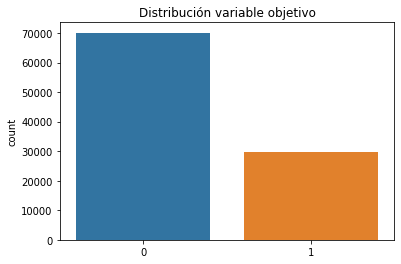

In [8]:
print(df['empeora_mora'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x=empeora_mora, data=df)
plt.title("Distribución variable objetivo")
plt.show()

## Análisis exploratorio de los datos

In [9]:
# pip install summarytools

from summarytools import dfSummary

In [10]:
def eda(df, target):
    print("=== Tipos de variables ===")
    print(df.dtypes)
    print("\n=== Estadísticas descriptivas variables numéricas ===")
    print(df.describe().T)
    print("\n=== Estadísticas variables categóricas ===")
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        print(f"\nVariable: {col}")
        print(df[col].value_counts())
        print(df.groupby(col)[target].mean().sort_values(ascending=False))
    print("\n=== Distribución variable objetivo ===")
    print(df[target].value_counts(normalize=True))
    # Visualización simple
    plt.figure(figsize=(6,4))
    sns.countplot(x=target, data=df)
    plt.title("Distribución variable objetivo")
    plt.show()

=== Tipos de variables ===
empeora_mora              int64
genero                   object
edad                      int64
ingresos                float64
egresos                 float64
patrimonio              float64
nivelEndeudamiento      float64
relacionDeudaIngreso    float64
estadoCivil              object
educacion                object
vivienda                 object
aniosTrabajo              int64
tipoCredito              object
montoCredito            float64
plazoCuotas               int64
nroCuentas                int64
nroPolizas                int64
nroTarjetasCredito        int64
nroCreditosSistFinan      int64
nroTarjCredSistFinan      int64
deudaSistFinan          float64
scoreBuro               float64
experienciaSistFinan      int64
pagoCuotaUltMes01         int64
diasMoraUltMes01        float64
saldoCuentasUltMes01    float64
pagoCuotaUltMes02         int64
diasMoraUltMes02        float64
saldoCuentasUltMes02    float64
pagoCuotaUltMes03         int64
diasMoraUltMe

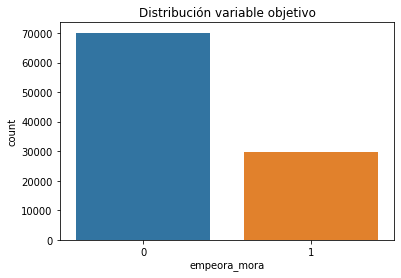

In [11]:
target = 'empeora_mora'

eda(df, target)

In [12]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,empeora_mora[int64],1. 02. 1,"70,111 (70.1%)29,889 (29.9%)",,0(0.0%)
2,genero[object],1. F2. M,"50,166 (50.2%)49,834 (49.8%)",,0(0.0%)
3,edad[int64],Mean (sd) : 48.0 (11.7)min < med < max:25.0 < 48.0 < 69.0IQR (CV) : 20.0 (4.1),45 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAAsTAAALEwEAmpwYAAABQklEQVR4nO3asU3EMABAUYOQ0pg2V9CgLAALMMRN4Ja1MgFTsAcNBandRIoUFuCkmFwcXf5/deSz9C0n8eVunueg47vfewKq46H2D7Zte44xnpZcm3P+GYbh44hzqK166BjjKaX0veTavu+fbmkOJQsohLqLqHroIytZQCFst5D/4j0awtAQhoYwNIShIQwNYWiIq7xHlxwUTNP0EkJY9K45juNr13XvS67NOT/HGL/2nEPJuKVjrz1cuUrowpOmt6XjNk3zWDJuSulz7zksHfcfY686XHHrhjA0hKEh/FPjRqx9cDP0jVj74ObWDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNcfELk62+1dY+Lobe6ltt7cOtG8LQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0xC87J3lw1UZdNQAAAABJRU5ErkJggg=="">",0(0.0%)
4,ingresos[float64],Mean (sd) : 3754.0 (1557.3)min < med < max:500.0 < 3833.5 < 9483.9IQR (CV) : 2552.6 (2.4),"99,772 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAAsTAAALEwEAmpwYAAABTUlEQVR4nO3bMc6CMByG8WpMYKgrDm5cwO8CHsITdPVaPYGbN3KQmYWEBE9gvjaW0vR9fjNDkyf+KRV2y7IY1G+/9QKQx2HrBaTSdd3NWnsKuXYcx/cwDI+111SSakJba0/OuVfItd7789rrKQ2jWwShRRBaBKFFJNmMseMtX5LQ7HjLx+gWUfRzdMwtYZ7nizEmaKooyh56mqa/vu/vIde2bXtxzj1DrvXeX39bWd2yh26a5hhxPydeIkWP7rXETJVanhIkQ0dOlSqeEth1iyC0CEKLILQIQosgtAhCiyC0CEKLILQIQosgtAhCiyC0CEKLILQIQosgtAjJV4li1PJ+GaH/Ucv7ZYxuEYQW8XV08zlMXb6GjvxCki8qCsfoFkFoEYQWQWgRhBZBaBEcgSYUcy5uTN6zcUInFHMubkzes3FGtwh+0RvK+RfoB68ibzmIYWcKAAAAAElFTkSuQmCC"">",0(0.0%)
5,egresos[float64],Mean (sd) : 2229.5 (802.4)min < med < max:205.4 < 2149.2 < 6161.0IQR (CV) : 1081.5 (2.8),"100,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAAsTAAALEwEAmpwYAAABN0lEQVR4nO3bsWnEMABAUSUcuFFaX5EmeIFkgQyRCdRmLU9wU2SPNCni2o3B4ExwROIUBfT/qwUWfJCxJN8dxxHUv/v/noDaOLV+4DiObzHGc87YdV2fYoyfmWO/l2W53DS5jjUPHWM8p5S+csbO8/yaUvrIHPt428z65tINYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhml88+Cvbtr1M0/SeM5Z4G6Wb0MMwPBTcXMHdRnHphjA0hKEhDA1haAhDQ1T5vCr5+2Lf9+cQQtZnkOqpErr074saz1QZl24IQ0MYGsLQEIaG6Ob0qgTxSBMZmnik6dINYWgIQ0MYGsLQEIaGMDSEoSGQGyYletlFM/QvetlFuxra60F9uRra60F9cemuqOR9HkLbd/oP6y5i8JZmEBYAAAAASUVORK5CYII="">",0(0.0%)
6,patrimonio[float64],Mean (sd) : 58064.0 (31926.5)min < med < max:1000.0 < 54783.4 < 199723.9IQR (CV) : 47859.6 (1.8),"98,359 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAAsTAAALEwEAmpwYAAABMklEQVR4nO3asW2DQBhA4UsUiebS4iIdCyQLZIhMQJu1mCBTuTA1DRISmcAOJ/05W/feVyOD9MTx++Bp3/ek9j3f+wJUx0vEj/R9/5VzPh05dlmWyzzPPxHn1XEhoXPOp3Ecz0eOnabpLeKcKhMSusS6rh/DMHwfOda7P0710F3XvXr31+cwBmFoCENDGBqi+jBWwgk9zkOHdkKP49INYWgIQ0MYGsLQEIaGMDTEQ/+PLuHmym3NhHZz5TaXbghDQxgawtAQV4exkk94t217TykdGoR0H1dDF37C+xl3SfoPLt0QhoYwNIShIQwNYWgIQ0M08/aqBPGVJjI08ZWmSzeEoSEMDWFoCENDGBrC0BCGhkBumJRoZRfN0H9oZRfNpRvC0BCGhvAZHahkcEup7vD2C0U3cDlI2SZ7AAAAAElFTkSuQmCC"">",0(0.0%)
7,nivelEndeudamiento[float64],Mean (sd) : 1.0 (0.6)min < med < max:0.2 < 0.8 < 2.5IQR (CV) : 0.9 (1.5),"100,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAAsTAAALEwEAmpwYAAABTUlEQVR4nO3cMU6EQABAUTQmUIwtW9gYLrBeYE9g5Qmm9Ux0nMDOG3gPGwupaTYhYRtbcMYE3PD/a3cymeQnQzKwczNNU6H9u/3vBWgbd3M/1HX9EkI4pEwyDMNjCOFzhbHffd+/pYzVstnQIYRDjPErZZKu604xxo8Vxj6kjNPv3LohDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhpj9rvsanM/np6

## Selección de variables

Calculo del valor de la información (Informacion Value [IV]) para seleccinar las variables más relevantes.

In [13]:
def calc_iv(df, feature, target, bins=10):
    """
    Calcula IV para variable numérica o categórica.
    """
    df2 = pd.DataFrame()
    if df[feature].dtype.kind in 'bifc':  # numérica
        df[feature+'_bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
        grouped = df.groupby(feature+'_bin')
    else:
        grouped = df.groupby(feature)
    iv_df = grouped[target].agg(['count','sum'])
    iv_df['non_event'] = iv_df['count'] - iv_df['sum']
    iv_df['event_rate'] = iv_df['sum'] / iv_df['sum'].sum()
    iv_df['non_event_rate'] = iv_df['non_event'] / iv_df['non_event'].sum()
    iv_df = iv_df.replace({'event_rate': {0: 0.0001}, 'non_event_rate': {0: 0.0001}})
    iv_df['woe'] = np.log(iv_df['event_rate'] / iv_df['non_event_rate'])
    iv_df['iv'] = (iv_df['event_rate'] - iv_df['non_event_rate']) * iv_df['woe']
    iv = iv_df['iv'].sum()
    if df[feature].dtype.kind in 'bifc':
        df.drop(columns=[feature+'_bin'], inplace=True)
    return iv

def iv_selection(df, target, threshold=0.02):
    iv_values = {}
    features = [f for f in df.columns if f != target]
    for f in features:
        try:
            iv = calc_iv(df, f, target)
            iv_values[f] = iv
        except Exception as e:
            # Para variables no numéricas no tratadas, se ignora o se puede codificar antes
            iv_values[f] = 0
    iv_df = pd.DataFrame.from_dict(iv_values, orient='index', columns=['IV'])
    iv_df = iv_df.sort_values(by='IV', ascending=False)
    print("\n=== IV de variables ===")
    print(iv_df)
    selected = iv_df[iv_df['IV'] >= threshold].index.tolist()
    print(f"\nVariables seleccionadas con IV >= {threshold}: {selected}")
    return selected

In [14]:
selected_iv = iv_selection(df, target, threshold=0.02)


=== IV de variables ===
                                IV
diasMoraUltMes01      1.448490e+01
nivelEndeudamiento    1.443408e+01
relacionDeudaIngreso  1.443408e+01
experienciaSistFinan  1.346477e+01
diasMoraUltMes02      1.330438e+01
diasMoraUltMes03      1.104278e+01
aniosTrabajo          9.952128e+00
scoreBuro             9.653499e+00
nroCreditosSistFinan  9.586621e+00
deudaSistFinan        8.790624e+00
plazoCuotas           8.053740e+00
ingresos              7.421995e+00
nroTarjCredSistFinan  6.891059e+00
nroTarjetasCredito    6.889195e+00
nroCuentas            6.884098e+00
diasMoraUltMes04      6.701122e+00
saldoCuentasUltMes03  6.532201e+00
saldoCuentasUltMes01  6.446638e+00
saldoCuentasUltMes02  6.435438e+00
nroPolizas            6.127870e+00
saldoCuentasUltMes04  5.747472e+00
saldoCuentasUltMes05  5.487206e+00
saldoCuentasUltMes06  5.022212e+00
patrimonio            4.327753e+00
diasMoraUltMes05      4.038671e+00
diasMoraUltMes06      2.392274e+00
egresos               1.806926

Una segunda fase de descarte de variables es la identificación de variables altamente correlacionadas, dado que incluyen en la capacidad de predición del modelo. Así, la decisión para descartar variables es la siguiente: Se descartan variables con una correlación mayor a 70% en valor absoluto.

In [15]:
def corr_selection(df, features, threshold=0.7):
    corr_matrix = df[features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    selected = [f for f in features if f not in to_drop]
    print(f"\nVariables descartadas por correlación > {threshold}: {to_drop}")
    print(f"Variables seleccionadas tras filtro de correlación: {selected}")
    return selected

In [16]:
selected_corr = corr_selection(df, selected_iv, threshold=0.7)


Variables descartadas por correlación > 0.7: ['nivelEndeudamiento', 'relacionDeudaIngreso', 'experienciaSistFinan', 'diasMoraUltMes02', 'diasMoraUltMes03', 'scoreBuro', 'deudaSistFinan', 'ingresos', 'diasMoraUltMes04', 'saldoCuentasUltMes01', 'saldoCuentasUltMes02', 'nroPolizas', 'saldoCuentasUltMes04', 'saldoCuentasUltMes05', 'saldoCuentasUltMes06', 'diasMoraUltMes05', 'diasMoraUltMes06', 'egresos']
Variables seleccionadas tras filtro de correlación: ['diasMoraUltMes01', 'aniosTrabajo', 'nroCreditosSistFinan', 'plazoCuotas', 'nroTarjCredSistFinan', 'nroTarjetasCredito', 'nroCuentas', 'saldoCuentasUltMes03', 'patrimonio', 'montoCredito', 'edad', 'estadoCivil', 'educacion', 'vivienda', 'tipoCredito']


/tmp/ipykernel_2735/1122717692.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr().abs()


In [17]:
def plot_correlation_matrix(df, selected_features):
    # Filtrar solo variables numéricas seleccionadas
    df_num = df[selected_features].select_dtypes(include=[np.number])
    corr = df_num.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(12,10))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f", 
                square=True, linewidths=.5, cbar_kws={"shrink": .75}, center=0)
    plt.title("Matriz de Correlación - Variables Seleccionadas", fontsize=16)
    plt.show()

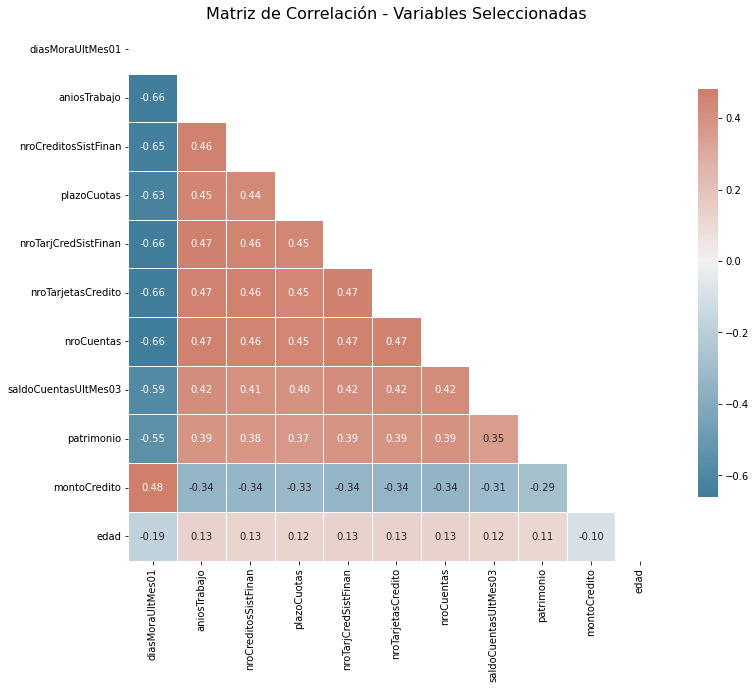

In [18]:
plot_correlation_matrix(df, selected_corr)

## Construcción del modelo predictivo (Clasificación binaria)

In [19]:
# %pip install xgboost pandas sklearn
# %pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix)

import warnings
warnings.filterwarnings('ignore')

/var/sds/packages/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [20]:
print(f"variables finales para el modelo: {df[selected_corr + [target]].columns}")

variables finales para el modelo: Index(['diasMoraUltMes01', 'aniosTrabajo', 'nroCreditosSistFinan',
       'plazoCuotas', 'nroTarjCredSistFinan', 'nroTarjetasCredito',
       'nroCuentas', 'saldoCuentasUltMes03', 'patrimonio', 'montoCredito',
       'edad', 'estadoCivil', 'educacion', 'vivienda', 'tipoCredito',
       'empeora_mora'],
      dtype='object')


### Creación de conjuntos de datos Train (60%), Test (30%) y Validation (10%)

In [21]:
def split_data(df, target):
    train, temp = train_test_split(df, test_size=0.4, stratify=df[target], random_state=42)
    test, validation = train_test_split(temp, test_size=0.25, stratify=temp[target], random_state=42)  # 0.25 * 0.4 = 0.1
    print(f"\nTamaños conjuntos: TRAIN={len(train)}, TEST={len(test)}, VALIDATION={len(validation)}")
    return train, test, validation

In [22]:
train_df, test_df, val_df = split_data(df[selected_corr + [target]], target)


Tamaños conjuntos: TRAIN=60000, TEST=30000, VALIDATION=10000


### Prepocesado de las variables categóricas (one-hot-encoding)

In [23]:
def preprocess(df, target, selected_features):
    df_proc = df.copy()
    cat_cols = [col for col in df_proc.select_dtypes(include=['object']).columns if col in selected_features]

    for col in cat_cols:
        if col in df_proc.columns:
            df_proc = pd.get_dummies(df_proc, columns=[col], drop_first=True)
        else:
            print(f"Warning: Categorial columns {col} not found in DataFrame")
            selected_features.remove(col) #Removes column if not in dataframe
    # Seleccionar variables
    X = df_proc.drop(target, axis=1)
    y = df_proc[target]
    return X, y

In [24]:
X_train, y_train = preprocess(train_df, target, selected_corr)
X_test, y_test = preprocess(test_df, target, selected_corr)
X_val, y_val = preprocess(val_df, target, selected_corr)

Se corrigen las posibles diferencias entre las columnas entre los diferentes conjuntos de datos.

In [25]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

### Balanceo de datos con algoritmo SMOTE

In [26]:
def balance_data(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"Tamaño TRAIN balanceado: {len(X_train_bal)}")
    return X_train_bal, y_train_bal

In [27]:
X_train_bal, y_train_bal = balance_data(X_train, y_train)

Tamaño TRAIN balanceado: 84134


### Tuneo de hiperparámetros y Cross Validation

In [28]:
def tune_model(model, param_grid, X_train, y_train):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0, return_train_score=True)
    grid.fit(X_train, y_train)
    return grid

In [29]:
# Parámetros para tuning (puedes ajustar según tiempo y recursos)
dt_params = {'max_depth': [3,5,7,9, None], 'min_samples_split':[2,5,10]}
rf_params = {'n_estimators':[50,100], 'max_depth':[5,7, None], 'min_samples_split':[2,5]}
xgb_params = {'n_estimators':[50,100], 'max_depth':[3,5,7], 'learning_rate':[0.01,0.1]}

In [ ]:
print("\nTuning Decision Tree...")
dt_grid = tune_model(DecisionTreeClassifier(random_state=42), dt_params, X_train_bal, y_train_bal)
print(f"Mejor Decision Tree: {dt_grid.best_params_} - Accuracy: {dt_grid.best_score_:.4f}")

print("\nTuning Random Forest...")
rf_grid = tune_model(RandomForestClassifier(random_state=42), rf_params, X_train_bal, y_train_bal)
print(f"Mejor Random Forest: {rf_grid.best_params_} - Accuracy: {rf_grid.best_score_:.4f}")

print("\nTuning XGBoost...")
xgb_grid = tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train_bal, y_train_bal)
print(f"Mejor XGBoost: {xgb_grid.best_params_} - Accuracy: {xgb_grid.best_score_:.4f}")


Tuning Decision Tree...
Mejor Decision Tree: {'max_depth': 3, 'min_samples_split': 2} - Accuracy: 1.0000

Tuning Random Forest...
Mejor Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50} - Accuracy: 1.0000

Tuning XGBoost...


### Comparación de los algoritmos con sus respectivas iteraciones

In [ ]:
def plot_simple(grid, model_name, ylimit=None):
    results = pd.DataFrame(grid.cv_results_)
    # param_cols = [c for c in results.columns if c.startswith('param_')]
    # param_name = param_cols[0].replace('param_', '') if param_cols else 'param'
    acc_train = results['mean_train_score']
    acc_test = results['mean_test_score']
    
    plt.figure(figsize=(8,5))
    plt.plot(range(len(acc_train)), acc_train, label='Train Accuracy')
    plt.plot(range(len(acc_train)), acc_test, label='Test Accuracy')
    
    plt.xlabel('Nro. Modelo')
    if ylimit is not None:
        plt.ylim(ylimit[0], ylimit[1])
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Train vs Test - {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plot_simple(dt_grid, "Decision Tree", [0.999, 1.0001])

In [ ]:
plot_simple(rf_grid, "Random Forest", [0.999, 1.0001])

In [ ]:
plot_simple(xgb_grid, "XGBoost")

### Comparación de feature importance de los algoritmos con mejor hiperparámetros

In [ ]:
def plot_feature_importance(model, features, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        fi = pd.Series(importances, index=features).sort_values(ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title(f'Importancia de variables - {model_name}')
        plt.show()
    else:
        print(f"El modelo {model_name} no tiene atributo feature_importances_")

In [ ]:
best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

In [ ]:
plot_feature_importance(best_dt, X_train.columns, "Decision Tree")

In [ ]:
plot_feature_importance(best_rf, X_train.columns, "Random Forest")

In [ ]:
plot_feature_importance(best_xgb, X_train.columns, "XGBoost")

### Algoritmo y iteración ganadora

Se observa que lgoritmos *Decision Tree* y *Randon Forest* muestran valores de 100% en Train y 100% Test en todas las iteraciones, esto puede ser un indicador de sobre ajuste dada que es muy sospechoso obtener dichos valores en varias iteraciones. Por otro lado, el algoritmo *Xgboost* muestra un comportamiento variable en todas sus iteraciones y una mejora lo largo de ellas lo que es muy usual en el entrenamiento de un modelo. Por tanto, el algoritmo ganador es el *Xgboost*.  

In [ ]:
params_temp = pd.DataFrame(xgb_grid.cv_results_)

acc_train = []
acc_test = []
acc_val = []
for x, y, p in zip(params_temp['mean_test_score'], params_temp['mean_train_score'], params_temp['params']):
    p_learning_rate = p['learning_rate']
    p_max_depth = p['max_depth']
    p_n_estimators = p['n_estimators']
    
    model_ganador_temp = XGBClassifier(objective = 'binary:logistic', 
                                  n_estimators = p_n_estimators, 
                                  learning_rate = p_learning_rate, 
                                  max_depth = p_max_depth)
    model_ganador_temp.fit(X_train_bal, y_train_bal)

    y_pred_val = model_ganador_temp.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    
    acc_train.append(x)
    acc_test.append(y)
    acc_val.append(accuracy_val)


    
plt.figure(figsize=(12,5))
plt.plot(range(len(acc_train)), acc_train, label='Train Accuracy')
plt.plot(range(len(acc_train)), acc_test, label='Test Accuracy')
plt.plot(range(len(acc_train)), acc_val, label='Val Accuracy')
plt.legend()

pd.DataFrame({'acc_train':acc_train, 'acc_test':acc_test, 'acc_val':acc_val}).iloc[1]

### Importancia dd variables de la iteración ganadora

Hiperparámetros de la iteración ganadora:
* 'learning_rate': 0.01
* 'max_depth': 3
* 'n_estimators': 100

In [ ]:
model_ganador = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.01, max_depth=3)
model_ganador.fit(X_train_bal, y_train_bal)

y_pred_train = model_ganador.predict(X_train)
y_pred_test = model_ganador.predict(X_test)
y_pred_val = model_ganador.predict(X_val)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
acc_val = accuracy_score(y_val, y_pred_val)

print(f"Accuracy - Train: {acc_train}")
print(f"Accuracy - Test: {acc_test}")
print(f"Accuracy - Validation: {acc_val}")

In [ ]:
plot_feature_importance(model_ganador, X_train.columns, "xgboot")

## Evaluación y métricas del modelo e iteración ganadora

In [ ]:
def predict_and_metrics(model, X, y_true):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)  # sensibilidad
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    especificidad = tn / (tn + fp)
    gini = 2*auc - 1
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'F1-score': f1,
            'auc': auc, 'especificidad': especificidad, 'gini': gini, 'cm' : cm,
            'y_true' : y_true.values, 'y_pred': y_pred, 'y_prob': y_prob}

In [ ]:
result_metrics_train = predict_and_metrics(model_ganador, X_train, y_train)
result_metrics_test = predict_and_metrics(model_ganador, X_test, y_test)
result_metrics_val = predict_and_metrics(model_ganador, X_val, y_val)

In [ ]:
list_metrics = ['accuracy', 'precision', 'recall', 'F1-score', 'auc', 'gini']

df_metricas = pd.DataFrame(
    {
        'métrica' : list_metrics,
        'train' : [result_metrics_train[it] for it in list_metrics],
        'test'  : [result_metrics_test[it] for it in list_metrics],
        'validation' : [result_metrics_val[it] for it in list_metrics]
    }
)

df_metricas

In [ ]:
plt.figure(figsize=(14,5))
plt.title('Comparación de las métricas en los conjuntos de Train, Test y Validation')
plt.plot(df_metricas['métrica'], df_metricas['train'], label='Train set')
plt.scatter(df_metricas['métrica'], df_metricas['train'])
plt.plot(df_metricas['métrica'], df_metricas['test'], label='Test set')
plt.scatter(df_metricas['métrica'], df_metricas['test'])
plt.plot(df_metricas['métrica'], df_metricas['validation'], label='Validation set')
plt.scatter(df_metricas['métrica'], df_metricas['validation'])
plt.legend()
plt.show()

In [ ]:
# Calcular matrices de confusión
cm1 = result_metrics_train['cm']
cm2 = result_metrics_test['cm']
cm3 = result_metrics_val['cm']

# Crear un gráfico con tres matrices de confusión una al lado de la otra
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm1, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Conjunto de Train')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

sns.heatmap(cm2, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Conjunto de Test')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

sns.heatmap(cm3, annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Conjunto de Validation')
axes[2].set_xlabel('Predicción')
axes[2].set_ylabel('Real')

plt.tight_layout()
plt.show()


In [ ]:
# Calcular las curvas ROC y AUC
fpr1, tpr1, _ = roc_curve(result_metrics_train['y_true'], result_metrics_train['y_prob'])
fpr2, tpr2, _ = roc_curve(result_metrics_test['y_true'], result_metrics_test['y_prob'])
fpr3, tpr3, _ = roc_curve(result_metrics_val['y_true'], result_metrics_val['y_prob'])

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# Graficar las curvas ROC
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc1:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Conjunto de Train')
plt.legend(loc="lower right")

plt.subplot(1, 3, 2)
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc2:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Conjunto de Test')
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(fpr3, tpr3, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc3:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Conjunto de Validation')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()